<center>
# Solving initial value problems (IVPs) in `quantecon`

## David R. Pugh


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import sympy as sp

# comment out if you don't want plots rendered in notebook
%matplotlib inline

# 1. Introduction
This notebook demonstrates how to solve initial value problems (IVPs) using the [`quantecon`](http://jstac.github.io/quant-econ/) Python library. Before demonstrating how one might solve an IVP using `quantecon`, I provide formal definitions for ordinary differential equations (ODEs) and initial value problems (IVPs), as well as a short discussion of finite-difference methods that will be used to solve IVPs.

## Ordinary differential equations (ODE)
An [ordinary differential equation (ODE)](http://en.wikipedia.org/wiki/Ordinary_differential_equation) is in equation of the form

\begin{equation}
\textbf{y}'= \textbf{f}(t ,\textbf{y}) \tag{1.1}
\end{equation}

where $\textbf{f}:[t_0,\infty) \times \mathbb{R}^n\rightarrow\mathbb{R}^n$.  In the case where $n=1$, then equation 1.1 reduces to a single ODE; when $n>1$, equation 1.1 defines a system of ODEs. ODEs are one of the most basic examples of functional equations: a solution to equation 1.1 is a function $\textbf{y}(t): D \subset \mathbb{R}\rightarrow\mathbb{R}^n$. There are potentially an infinite number of solutions to the ODE defined in equation 1.1. In order to reduce the number of potentially solutions, we need to impose a bit more structure on the problem. 

## Initial value problems (IVPs)
An [initial value problem (IVP)](http://en.wikipedia.org/wiki/Initial_value_problem) has the form

\begin{equation}
\textbf{y}'= \textbf{f}(t ,\textbf{y}),\ t \ge t_0,\ \textbf{y}(t_0) = \textbf{y}_0 \tag{1.2}
\end{equation}

where $\textbf{f}:[t_0,\infty) \times \mathbb{R}^n\rightarrow\mathbb{R}^n$ and the initial condition $\textbf{y}_0 \in \mathbb{R}^n$ is a given vector. Alternatively, I could also specify an initial value problem by imposing a terminal condition of the form $\textbf{y}(T) = \textbf{y}_T$. The key point is that the solution $\textbf{y}(t)$ is pinned down at one $t\in[t_0, T]$. 

The solution to the IVP defined by equation 1.2 is the function $\textbf{y}(t): [t_0,T] \subset \mathbb{R}\rightarrow\mathbb{R}^n$ that satisfies the initial condition $\textbf{y}(t_0) = \textbf{y}_0$.  So long as the function $\textbf{f}$ is [reasonably well-behaved](http://en.wikipedia.org/wiki/Ordinary_differential_equation#Existence_and_uniqueness_of_solutions), the solution $\textbf{y}(t)$ exists and is unique.

## Finite-difference methods
[Finite-difference methods](http://en.wikipedia.org/wiki/Finite_difference_method) are perhaps the most commonly used class of numerical methods for approximating solutions to IVPs. The basic idea behind all finite-difference  methods is to construct a difference equation 

\begin{equation}
\frac{\textbf{y}(t_i + h) - \textbf{y}_i}{h} \approx \textbf{y}'(t_i) = \textbf{f}(t_i ,\textbf{y}(t_i)) \tag{1.3}
\end{equation}

which is "similar" to the differential equation at some grid of values $t_0 < \dots < t_N$. Finite-difference methods then "solve" the original differential equation by finding for each $n=0,\dots,N$ a value $\textbf{y}_n$ that approximates the value of the solution $\textbf{y}(t_n)$.

It is important to note that finite-difference methods only approximate the solution $\textbf{y}$ at the $N$ grid points. In order to approximate $\textbf{y}$ between grid points one must resort to some form of [interpolation](http://en.wikipedia.org/wiki/Interpolation). 

The literature on finite-difference methods for solving IVPs is vast and there are many excellent reference texts. Those interested in a more in-depth treatment of these topics, including formal proofs of convergence, order, and stability of the numerical methods used in this notebook, should consult <cite data-cite="hairer1993solving">(Hairer, 1993)</cite>, <cite data-cite="butcher2008numerical">(Butcher, 2008)</cite>, <cite data-cite="iserles2009first">(Iserles, 2009)</cite>. Chapter 10 of <cite data-cite="judd1998numerical">(Judd, 1998)</cite> covers a subset of these more formal texts with a specific focus on economic applications. 

# 2. Examples
The remainder of this notebook demonstrates the usage and functionality of the `quantecon.ivp` module by way of example. To get started, we need to import the `quantecon.ivp module`...

In [2]:
from quantecon import ivp

## 2.1 Lotka-Volterra "Predator-Prey" model

We begin with the Lotka-Volterra model, also known as the predator-prey model, which is a pair of first order, non-linear, differential equations frequently used to describe the dynamics of biological systems in which two species interact, one a predator and the other its prey. The model was proposed independently by Alfred J. Lotka in 1925 and Vito Volterra in 1926. 

\begin{align}
    \frac{du}{dt} =& au - buv \tag{2.1.1} \\
    \frac{dv}{dt} =& -cv + dbuv \tag{2.1.2}
\end{align}

where $u$ is the number of preys (for example, rabbits), $v$ is the number of predators (for example, foxes) and $a, b, c, d$ are constant parameters defining the behavior of the population.

Parameter definitions are as follows:
* $a$: the natural growing rate of prey in the absence of predators.
* $b$: the natural dying rate of prey due to predation.
* $c$: the natural dying rate of predators, in teh absence of prey.
* $d$: the factor describing how many caught prey is necessary to create a new predator.

I will use $\textbf{y}=[u, v]$ to describe the state of both populations.

### 2.1.1 Defining an instance of the `IVP` class

First, we need to create an instance of the IVP class representing the Lotka-Volterra "Predator-Prey" model. To initialize an instance of the IVP class we need to define the following...

* ``f`` : Callable of the form ``f(t, y, *f_args)``. The function ``f`` is the right hand side of the system of equations defining the model. The independent variable, ``t``, should be a ``scalar``; ``y`` is an ``ndarray`` of dependent variables with ``y.shape == (n,)``. The function `f` should return a ``scalar``, ``ndarray`` or ``list`` (but not a ``tuple``).
* ``jac`` : Callable of the form ``jac(t, y, *jac_args)``, optional(default=None). The Jacobian of the right hand side of the system of equations defining the ODE.

$$ \mathcal{J}_{i,j} = \bigg[\frac{\partial f_i}{\partial y_j}\bigg] \tag {2.1.3}$$

Most all of this information can be found in the docstring for the `ivp.IVP` class.

In [3]:
ivp.IVP?

From the docstring we see that we are required to define a function describing the right-hand side of the system of differential equations that we wish to solve. While, optional, it is always a good idea to also define a function describing the Jacobian matrix of partial derivatives.

For the Lotka-Volterra model, these two functions would look as follows...

In [4]:
def lotka_volterra_system(t, y, a, b, c, d):
    """
    Return the Lotka-Voltera system.

    Parameters
    ----------
    t : float
        Time
    y : ndarray (float, shape=(2,))
        Endogenous variables of the Lotka-Volterra system. Ordering is
        `y = [u, v]` where `u` is the number of prey and `v` is the number of
        predators.
    a : float
        Natural growth rate of prey in the absence of predators.
    b : float
        Natural death rate of prey due to predation.
    c : float
        Natural death rate of predators, due to absence of prey.
    d : float
        Factor describing how many caught prey is necessary to create a new
        predator.

    Returns
    -------
    jac : ndarray (float, shape=(2,2))
        Jacobian of the Lotka-Volterra system of ODEs.

    """
    f = np.array([ a * y[0] -   b * y[0] * y[1] ,
                  -c * y[1] + d * b * y[0] * y[1] ])
    return f


def lotka_volterra_jacobian(t, y, a, b, c, d):
    """
    Return the Lotka-Voltera Jacobian matrix.

    Parameters
    ----------
    t : float
        Time
    y : ndarray (float, shape=(2,))
        Endogenous variables of the Lotka-Volterra system. Ordering is
        `y = [u, v]` where `u` is the number of prey and `v` is the number of
        predators.
    a : float
        Natural growth rate of prey in the absence of predators.
    b : float
        Natural death rate of prey due to predation.
    c : float
        Natural death rate of predators, due to absence of prey.
    d : float
        Factor describing how many caught prey is necessary to create a new
        predator.

    Returns
    -------
    jac : ndarray (float, shape=(2,2))
        Jacobian of the Lotka-Volterra system of ODEs.

    """
    jac = np.array([[a - b * y[1],   -b * y[0]],
                    [b * d * y[1],   -c + b * d * y[0]]])
    return jac

We can go ahead and create our instance of the `ivp.IVP` class representing the Lotka-Volterra model using the above defined functions as follows...

In [5]:
lotka_volterra_ivp = ivp.IVP(f=lotka_volterra_system,
                             jac=lotka_volterra_jacobian)

### 2.1.2 Defining model parameters

In order to simulate the model, however, we will need to supply values for the model parameters $a,b,c,d$. First, let's define some "reasonable" values.

In [6]:
# ordering is (a, b, c, d)
lotka_volterra_params = (1.0, 0.1, 1.5, 0.75)

In order to add these parameter values to our model we need to pass them as arguments to the `set_f_params` and `set_jac_params` methods of the newly created instance of the `ivp.IVP` class. Check the doctrings of the methods for information on the appropriate syntax...

In [7]:
lotka_volterra_ivp.set_f_params?

In [8]:
lotka_volterra_ivp.set_jac_params?

From the docstring we see that both the `set_f_params` and the `set_jac_params` methods take an arbitrary number of positional arguments. 

In [9]:
lotka_volterra_ivp.set_f_params(*lotka_volterra_params)
lotka_volterra_ivp.set_jac_params(*lotka_volterra_params)

...and we can inspect that values of these attributes and see that the return results are the same.

In [10]:
lotka_volterra_ivp.f_params

(1.0, 0.1, 1.5, 0.75)

In [11]:
lotka_volterra_ivp.jac_params

(1.0, 0.1, 1.5, 0.75)

Alternatively, we could just directly set the `f_params` and `jac_params` attributes without needing to explicitly call either the `set_f_params` and `set_jac_params` methods!

In [12]:
# I generally prefer to set attributes directly...
lotka_volterra_ivp.f_params = lotka_volterra_params

In [13]:
# ...result is the same
lotka_volterra_ivp.f_params

(1.0, 0.1, 1.5, 0.75)

### 2.1.3 Using `ivp.IVP.solve` to integrate the ODE

In order to solve a system of ODEs, the `ivp.IVP.solve` method provides an interface into the ODE integration routines provided in the  `scipy.integrate.ode` module. The method takes the following parameters...

* `t0` : float. Initial condition for the independent variable.
* `y0` : array_like (float, shape=(n,)). Initial condition for the dependent variables.
* `h` : float, optional(default=1.0). Step-size for computing the solution. Can be positive or negative depending on the desired direction of integration.
* `T` : int, optional(default=None). Terminal value for the independent variable. One of either `T` or `g` must be specified.
* `g` : Callable of the form ``g(t, y, args)``, optional(default=None). Provides a stopping condition for the integration. If specified user must also specify a stopping tolerance, `tol`.
* `tol` : float, optional (default=None). Stopping tolerance for the integration. Only required if `g` is also specifed.
* `integrator` : str, optional(default='dopri5') Must be one of 'vode', 'lsoda', 'dopri5', or 'dop853'
* `step` : bool, optional(default=False) Allows access to internal steps for those solvers that use adaptive step size routines. Currently only 'vode', 'zvode', and 'lsoda' support `step=True`.
* `relax` : bool, optional(default=False) Currently only 'vode', 'zvode', and 'lsoda' support `relax=True`.
* `**kwargs` : dict, optional(default=None). Dictionary of integrator specific keyword arguments. See the Notes section of the docstring for `scipy.integrate.ode` for a complete description of solver specific keyword arguments.

... and returns:

* `solution`: array_like (float). Simulated solution trajectory.

The above information can be found in the doctring of the `ivp.IVP.solve` method.

In [14]:
# remember...always read the docs!
ivp.IVP.solve?

#### Example usage
Using `dopri5`, an embedded Runge-Kutta method of order 4(5) with adaptive step size control due to [Dormand and Prince](http://en.wikipedia.org/wiki/Dormand%E2%80%93Prince_method), integrate the model forward from an initial condition of 10 rabbits and 5 foxes for 15 years.

In [15]:
# define the initial condition...
t0, y0 = 0, np.array([10, 5])

# ...and integrate!
solution = lotka_volterra_ivp.solve(t0, y0, h=1e-1, T=15, integrator='dopri5',
                                    atol=1e-12, rtol=1e-9)

#### Plotting the solution

Once we have computed the solution, we can plot it using the excellent [`matplotlib`](http://matplotlib.org/) Python library.

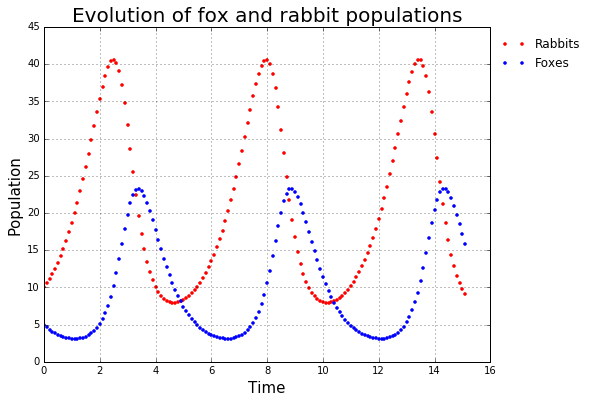

In [16]:
# extract the components of the solution trajectory
t = solution[:, 0]
rabbits = solution[:, 1]
foxes = solution[:, 2]

# create the plot
fig = plt.figure(figsize=(8, 6))
plt.plot(t, rabbits, 'r.', label='Rabbits')
plt.plot(t, foxes  , 'b.', label='Foxes')
plt.grid()
plt.legend(loc=0, frameon=False, bbox_to_anchor=(1, 1))
plt.xlabel('Time', fontsize=15)
plt.ylabel('Population', fontsize=15)
plt.title('Evolution of fox and rabbit populations', fontsize=20)
plt.show()

Note that we have plotted the time paths of rabbit and fox populations as sequences of points rather than smooth curves. This is done to visually emphasize the fact that finite-difference methods used to approximate the solution return a discrete approximation to the true continuous solution.

### 2.1.4 Using `ivp.IVP.interpolate` to interpolate the solution

The `IVP.interpolate` method provides an interface to the parametric [B-spline interpolation](http://en.wikipedia.org/wiki/B-spline) routines in `scipy.interpolate` in order to constuct a continuous approximation to the true solution. For more details on B-spline interpolation, including some additional economic applications, see chapter 6 of <cite data-cite="judd1998numerical">(Judd, 1998)</cite>. The `ivp.IVP.interpolate` method takes the following parameters... 

* `traj` : array_like (float)
    Solution trajectory providing the data points for constructing the
    B-spline representation.
* `ti` : array_like (float)
    Array of values for the independent variable at which to
    interpolate the value of the B-spline.
* `k` : int, optional(default=3)
    Degree of the desired B-spline. Degree must satisfy
    :math:`1 \le k \le 5`.
* `der` : int, optional(default=0)
    The order of derivative of the spline to compute (must be less
    than or equal to `k`).
* `ext` : int, optional(default=2) Controls the value of returned elements
    for outside the original knot sequence provided by traj. For
    extrapolation, set `ext=0`; `ext=1` returns zero; `ext=2` raises a
    `ValueError`.

... and returns:

* `interp_traj`: ndarray (float). The interpolated trajectory.

#### Example usage
Approximate the solution to the Lotka-Volterra model at 1000 evenly spaced points using a 5th order B-spline interpolation and no extrapolation.

In [17]:
# define the desired interpolation points...
ti = np.linspace(t0, solution[-1, 0], 1000)

# ...and interpolate!
interp_solution = lotka_volterra_ivp.interpolate(solution, ti, k=5, ext=2)

#### Plotting the interpolated solution

We can now plot the interpolated solution using `matplotlib` as follows...

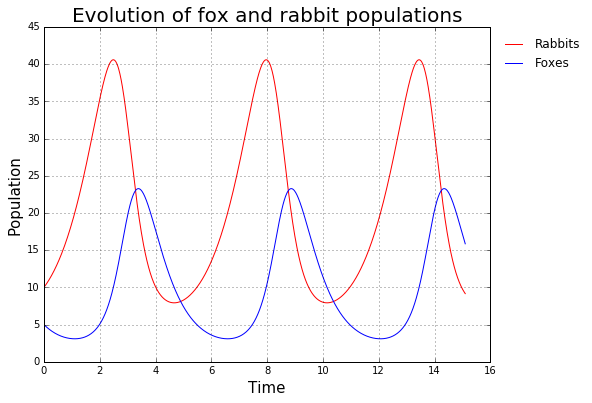

In [18]:
# extract the components of the solution
ti = interp_solution[:, 0]
rabbits = interp_solution[:, 1]
foxes = interp_solution[:, 2]

# make the plot
fig = plt.figure(figsize=(8, 6))

plt.plot(ti, rabbits, 'r-', label='Rabbits')
plt.plot(ti, foxes  , 'b-', label='Foxes')

plt.xlabel('Time', fontsize=15)
plt.ylabel('Population', fontsize=15)
plt.title('Evolution of fox and rabbit populations', fontsize=20)

plt.legend(loc='best', frameon=False, bbox_to_anchor=(1,1))
plt.grid()

plt.show()

Note that we have plotted the time paths of rabbit and fox populations as smooth curves. This is done to visually emphasize the fact that the B-spline interpolation methods used to approximate the solution return a continuous approximation to the true continuous solution.

### 2.1.5 Assessing accuracy using `ivp.IVP.compute_residual`

After computing a continuous approximation to the solution of our IVP, it is important to verify that the computed approximation is actually a "good" approximation. To assess the accuracy of our numerical solution we first define a residual function, $R(t)$, as the difference between the derivative of the B-spline approximation of the solution trajectory, $\hat{\textbf{y}}'(t)$, and the right-hand side of the original ODE evaluated along the approximated solution trajectory. 

\begin{equation}
    \textbf{R}(t) = \hat{\textbf{y}}'(t) - f(t, \hat{\textbf{y}}(t)) \tag{2.1.4}
\end{equation}

The idea is that if our numerical approximation of the true solution is "good", then this residual function should be roughly zero everywhere within the interval of approximation. The `ivp.IVP.compute_residual` method takes the following parameters...

* `traj` : array_like (float). Solution trajectory providing the data points for constructing the B-spline representation.
* `ti` : array_like (float). Array of values for the independent variable at which to interpolate the value of the B-spline.
* `k` : int, optional(default=3). Degree of the desired B-spline. Degree must satisfy $1 \le k \le 5$.
* `ext` : int, optional(default=2). Controls the value of returned elements for outside the original knot sequence provided by `traj`. For extrapolation, set `ext=0`; `ext=1` returns zero; `ext=2` raises a `ValueError`.

... and returns:

* `residual` : array (float) Difference between the derivative of the B-spline approximation of the solution trajectory and the right-hand side of the ODE evaluated along the approximated solution trajectory.

Remember to check the docstring for more information!

In [19]:
# life will be easier if you read the docs!
lotka_volterra_ivp.compute_residual?

#### Example usage
Compute the residual to the Lotka-Volterra model at 1000 evenly spaced points using a 1st order B-spline interpolation (which is equivalent to linear interpolation!).

In [20]:
# reset original parameters
lotka_volterra_ivp.f_params = lotka_volterra_params
lotka_volterra_ivp.jac_params = lotka_volterra_params

# compute the residual
residual = lotka_volterra_ivp.compute_residual(solution, ti, k=1)

#### Plotting the residual

In your introductory econometrics/statistics course, your professor likely implored you to "always plot your residuals!" This maxim of data analysis is no less true in numerical analysis. However, while patterns in residuals are generally a "bad" thing in econometrics/statistics (as they suggest model mispecification, or other related problems), patterns in a residual function, $\textbf{R}(t)$, in numerical analysis are generally OK (and in certain cases actually desireable!). 

In this context, what is important is that overall size of the residuals is "small".

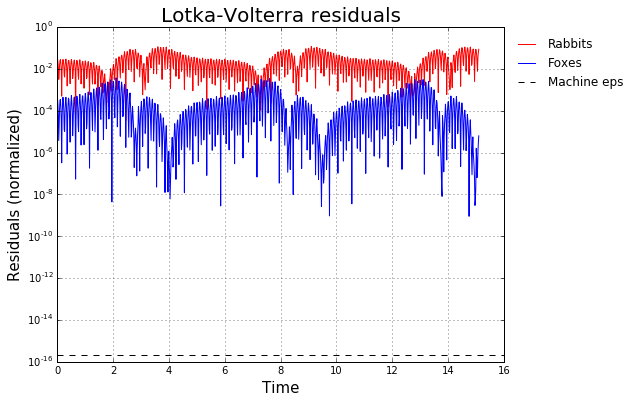

In [21]:
# extract the raw residuals
rabbits_residual = residual[:, 1]
foxes_residual = residual[:, 2]

# typically, normalize residual by the level of the variable
norm_rabbits_residual = np.abs(rabbits_residual) / rabbits
norm_foxes_residual = np.abs(foxes_residual) / foxes

# create the plot
fig = plt.figure(figsize=(8, 6))
plt.plot(ti, norm_rabbits_residual, 'r-', label='Rabbits')
plt.plot(ti, norm_foxes_residual**2 / foxes, 'b-', label='Foxes')
plt.axhline(np.finfo('float').eps, linestyle='dashed', color='k', label='Machine eps')
plt.xlabel('Time', fontsize=15)
plt.ylim(1e-16, 1)
plt.ylabel('Residuals (normalized)', fontsize=15)
plt.yscale('log')
plt.title('Lotka-Volterra residuals', fontsize=20)
plt.grid()
plt.legend(loc='best', frameon=False, bbox_to_anchor=(1,1))
plt.show()

#### Understanding determinants of accuracy
We can use [IPython widgets](http://nbviewer.ipython.org/github/ipython/ipython/blob/master/examples/Interactive%20Widgets/Index.ipynb) to investigate the determinants of accuracy of our approximated solution. Good candidates for exploration are... 

* `h`: the step size used in computing the initial finite difference solution. 
* `atol`: the absolute tolerance for the solver.
* `rtol`: the relative tolerance for the solver.
* `k`: the degree of the B-spline used in the interpolation of that finite difference solution.

In [22]:
from IPython.html.widgets import (interact, FloatTextWidget, FloatSliderWidget,
                                  IntSliderWidget, TextWidget)

ImportError: No module named 'widgets'

In [23]:
# reset parameters
lotka_volterra_ivp.f_params = (1.0, 0.1, 2.0, 0.75)
lotka_volterra_ivp.jac_params = lotka_volterra_ivp.f_params   

Now we can make use of the `@interact` decorator and the various IPython widgets to create an interactive visualization of the residual plot for the Lotka-Volterra "Predator-Prey" model.

In [24]:
@interact(h=FloatTextWidget(value=1e0), atol=FloatTextWidget(value=1e-3),
          rtol=FloatTextWidget(value=1e-3), k=IntSliderWidget(min=1, value=3, max=5), 
          integrator=TextWidget(value='lsoda'))
def plot_lotka_volterra_residuals(h, atol, rtol, k, integrator):
    """Plots residuals of the Lotka-Volterra system."""
    # re-compute the solution 
    tmp_solution = lotka_volterra_ivp.solve(t0, y0, h=h, T=15, integrator=integrator,
                                            atol=atol, rtol=rtol)

    # re-compute the interpolated solution and residual
    tmp_ti = np.linspace(t0, tmp_solution[-1, 0], 1000)
    tmp_interp_solution = lotka_volterra_ivp.interpolate(tmp_solution, tmp_ti, k=k)
    tmp_residual = lotka_volterra_ivp.compute_residual(tmp_solution, tmp_ti, k=k)
    
    # extract the components of the solution
    tmp_rabbits = tmp_interp_solution[:, 1]
    tmp_foxes = tmp_interp_solution[:, 2]

    # extract the raw residuals
    tmp_rabbits_residual = tmp_residual[:, 1]
    tmp_foxes_residual = tmp_residual[:, 2]

    # typically, normalize residual by the level of the variable
    tmp_norm_rabbits_residual = np.abs(tmp_rabbits_residual) / tmp_rabbits
    tmp_norm_foxes_residual = np.abs(tmp_foxes_residual) / tmp_foxes

    # create the plot
    fig = plt.figure(figsize=(8, 6))

    plt.plot(tmp_ti, tmp_norm_rabbits_residual, 'r-', label='Rabbits')
    plt.plot(tmp_ti, tmp_norm_foxes_residual**2 / foxes, 'b-', label='Foxes')
    plt.axhline(np.finfo('float').eps, linestyle='dashed', color='k', label='Machine eps')

    plt.xlabel('Time', fontsize=15)
    plt.ylim(1e-16, 1)
    plt.ylabel('Residuals (normalized)', fontsize=15)
    plt.yscale('log')
    plt.title('Lotka-Volterra residuals', fontsize=20)

    plt.grid()
    plt.legend(loc='best', frameon=False, bbox_to_anchor=(1,1))

    

NameError: name 'interact' is not defined

#### Sensitivity to parameters
Once we have computed and plotted an approximate solution (and verified that the approximation is a good one by plotting the residual function!), we can try and learn something about the dependence of the solution on model parameters.

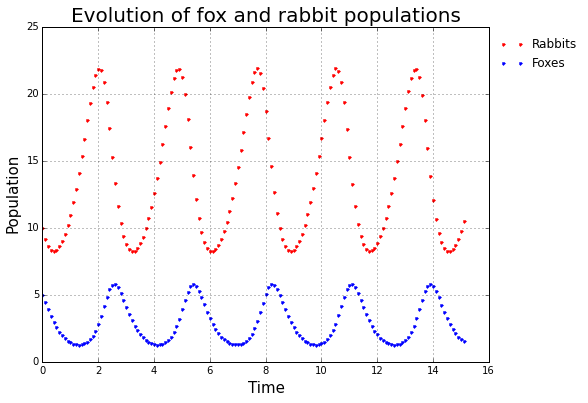

In [23]:
@interact(a=FloatSliderWidget(min=0.0, max=5.0, step=0.5, value=1.5),
          b=FloatSliderWidget(min=0.0, max=1.0, step=0.01, value=0.5), 
          c=FloatSliderWidget(min=0.0, max=5.0, step=0.5, value=3.5),
          d=FloatSliderWidget(min=0.0, max=1.0, step=0.01, value=0.5))
def plot_lotka_volterra(a, b, c, d):
    """Plots trajectories of the Lotka-Volterra system."""
    # update the parameters and re-compute the solution
    lotka_volterra_ivp.f_params = (a, b, c, d)
    lotka_volterra_ivp.jac_params = (a, b, c, d)
    tmp_solution = lotka_volterra_ivp.solve(t0, y0, h=1e-1, T=15, integrator='dopri5',
                                            atol=1e-12, rtol=1e-9)
    # extract the components of the solution
    tmp_t = tmp_solution[:, 0]
    tmp_rabbits = tmp_solution[:, 1]
    tmp_foxes = tmp_solution[:, 2]

    # create the plot!
    fig = plt.figure(figsize=(8, 6))
    
    plt.plot(tmp_t, tmp_rabbits, 'r.', label='Rabbits')
    plt.plot(tmp_t, tmp_foxes  , 'b.', label='Foxes')
    
    plt.xlabel('Time', fontsize=15)
    plt.ylabel('Population', fontsize=15)
    plt.title('Evolution of fox and rabbit populations', fontsize=20)

    plt.legend(loc='best', frameon=False, bbox_to_anchor=(1,1))
    plt.grid()
    

## 2.2 The Lorenz equations

The [Lorenz equations](Lorenz Equations`:http://en.wikipedia.org/wiki/Lorenz_system) are a system of three coupled, first-order, non-linear differential equations which describe the trajectory of a particle through time. The system was originally derived by as a model of atmospheric convection, but the deceptive simplicity of the equations have made them an often-used example in fields beyond atmospheric physics.

The equations describe the evolution of the spatial variables x, y, and z, given the governing parameters $\sigma, \beta, \rho$, through the specification of the time-derivatives of the spatial variables:

\begin{align}
    \frac{dx}{dt} =& \sigma(y − x) \tag{2.2.1} \\
    \frac{dy}{dt} =& x(\rho − z) − y \tag{2.2.2} \\
    \frac{dz}{dt} =& xy − \beta z \tag{2.2.3}
\end{align}

The resulting dynamics are entirely deterministic giving a starting point $(x_0,y_0,z_0)$. Though it looks straightforward, for certain choices of the parameters, the trajectories become chaotic, and the
resulting trajectories display some surprising properties.

### 2.2.1 Incorporating SymPy
While deriving the Jacobian matrix by hand is trivial for most simple 2D or 3D systems, it can quickly become tedious and error prone for larger systems (or even some highly non-linear 2D systems!). In addition to being an important input to most ODE integrators/solvers, Jacobians are also useful for assessing the stability properties of equilibria.

An alternative approach for solving IVPs using the `ivp` module, which leverages the [SymPy](http://sympy.org/en/index.html) Python library to do the tedious computations involved in deriving the Jacobian, is as follows.

1. Define the IVP using SymPy.
2. Use SymPy routines for computing the Jacobian.
3. Wrap the symbolic expressions as callable NumPy functions. 
4. Use these functions to create an instance of the `ivp.IVP` class.

The remainder of this notebook implements each of these steps to solve and analyze the Lorenz equations defined above.

#### Step 1: Defining the Lorenz equations using SymPy
We begin by defining a `sp.Matrix` instance containing the three Lorenz equations...

In [25]:
# enables sympy LaTex printing...
sp.init_printing()

In [26]:
# declare endogenous variables
t, x, y, z = sp.var('t, x, y, z')

# declare model parameters
beta, rho, sigma = sp.var('beta, rho, sigma')

# define symbolic model equations
_x_dot = sigma * (y - x)
_y_dot = x * (rho - z) - y
_z_dot = x * y - beta * z

# define symbolic system and compute the jacobian
_lorenz_system = sp.Matrix([[_x_dot], [_y_dot], [_z_dot]])

Let's take a check out our newly defined `_lorenz_system` and make sure it looks as expected...

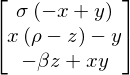

In [27]:
_lorenz_system

#### Step 2: Computing the Jacobian using SymPy
Once we have defined our model as a SymPy matrix, computing the Jacobian is trivial...

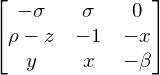

In [28]:
_lorenz_jacobian = _lorenz_system.jacobian([x, y, z])
_lorenz_jacobian

#### Step 3: Wrap the SymPy expression to create vectorized NumPy functions
Now we wrap the SymPy matrices defining the model and the Jacobian to create vectorized NumPy functions. It is crucial that the interface for our wrapped functions matches the interface required by the `f` and `jac` parameters which we will pass to the `ivp.IVP` constructor to create an instance of the `ivp.IVP` class representing the Lorenz equations.

Recall from the `ivp.IVP` docstring that... 

    f : callable `f(t, y, *f_args)`
        Right hand side of the system of equations defining the ODE. The
        independent variable, `t`, is a `scalar`; `y` is an `ndarray`
        of dependent variables with `y.shape == (n,)`. The function `f`
        should return a `scalar`, `ndarray` or `list` (but not a
        `tuple`).
    jac : callable `jac(t, y, *jac_args)`, optional(default=None)
        Jacobian of the right hand side of the system of equations defining
        the ODE.

        .. :math:

            \mathcal{J}_{i,j} = \bigg[\frac{\partial f_i}{\partial y_j}\bigg]
            
Thus our wrapped functions need to take a float `t` as the first argument, and array `y` as a second argument, followed by some arbitrary number of model parameters. We can handle all of this as follows...

In [29]:
# in order to pass an array as an argument, we need to apply a change of variables
X = sp.DeferredVector('X')
change_of_vars = {'x': X[0], 'y': X[1], 'z': X[2]}
_transformed_lorenz_system = _lorenz_system.subs(change_of_vars)
_transformed_lorenz_jacobian = _transformed_lorenz_system.jacobian([X[0], X[1], X[2]])

# wrap the symbolic expressions as callable numpy funcs
_args = (t, X, beta, rho, sigma)
_f = sp.lambdify(_args, _transformed_lorenz_system,
                 modules=[{'ImmutableMatrix': np.array}, "numpy"])
_jac = sp.lambdify(_args, _transformed_lorenz_jacobian,
                   modules=[{'ImmutableMatrix': np.array}, "numpy"])

#### Step 4: Use these functions to create an instance of the `IVP` class
First we define functions describing the right-hand side of the ODE and the Jacobian which we need to initialize the `ivp.IVP` class...

In [30]:
def lorenz_system(t, X, beta, rho, sigma):
    """
    Return the Lorenz system.

    Parameters
    ----------
    t : float
        Time
    X : ndarray (float, shape=(3,))
        Endogenous variables of the Lorenz system.
    beta : float
        Model parameter. Should satisfy :math:`0 < \beta`.
    rho : float
        Model parameter. Should satisfy :math:`0 < \rho`.
    sigma : float
        Model parameter. Should satisfy :math:`0 < \sigma`.


    Returns
    -------
    rhs_ode : ndarray (float, shape=(3,))
        Right hand side of the Lorenz system of ODEs.

    """
    rhs_ode = _f(t, X, beta, rho, sigma).ravel()
    return rhs_ode


def lorenz_jacobian(t, X, beta, rho, sigma):
    """
    Return the Jacobian of the Lorenz system.

    Parameters
    ----------
    t : float
        Time
    X : ndarray (float, shape=(3,))
        Endogenous variables of the Lorenz system.
    beta : float
        Model parameter. Should satisfy :math:`0 < \beta`.
    rho : float
        Model parameter. Should satisfy :math:`0 < \rho`.
    sigma : float
        Model parameter. Should satisfy :math:`0 < \sigma`.

    Returns
    -------
    jac : ndarray (float, shape=(3,3))
        Jacobian of the Lorenz system of ODEs.

    """
    jac = _jac(t, X, beta, rho, sigma)
    return jac

... next we define a tuple of model parameters...

In [31]:
# parameters with ordering (beta, rho, sigma)
lorenz_params = (2.66, 28.0, 10.0)


... finally, we are ready to create the instance of the `ivp.IVP` class representing the Lorenz equations.

In [32]:
# create the instance
lorenz_ivp = ivp.IVP(f=lorenz_system,
                     jac=lorenz_jacobian)

# specify the params
lorenz_ivp.f_params = lorenz_params
lorenz_ivp.jac_params = lorenz_params

### 2.2.2 Solving the Lorenz equations
At this point I proceed in exactly the same fashion as in the previous Lotka-Volterra equations example: 

1. Solve the model using a discretized, finite-difference approximation.
2. Use the discretized approximation in conjunction with parametric B-spline interpolation to construct a continuous approximation of the true solution.
3. Compute and analyze the residual of the approximate solution.

#### Step 1. Solve the model using a discretized, finite-difference approximation
Using `dop853`, an embedded Runge-Kutta method of order 7(8) with adaptive step size control due to [Dormand and Prince](http://en.wikipedia.org/wiki/Dormand%E2%80%93Prince_method), integrate the Lorenz equations forward from an initial condition of $X_0 = (1.0, 1.0, 1.0)$ from $t=0$, to $T=100$.

In [33]:
# declare and initial condition
t0, X0 = 0.0, np.array([1.0, 1.0, 1.0])

# solve!
solution = lorenz_ivp.solve(t0, X0, h=1e-2, T=100, integrator='dop853',
                            atol=1e-12, rtol=1e-9)

#### Plotting the solution time paths
We can use IPython widgets to construct a "poor man's" animation of the evolution of the Lorenz equations. 

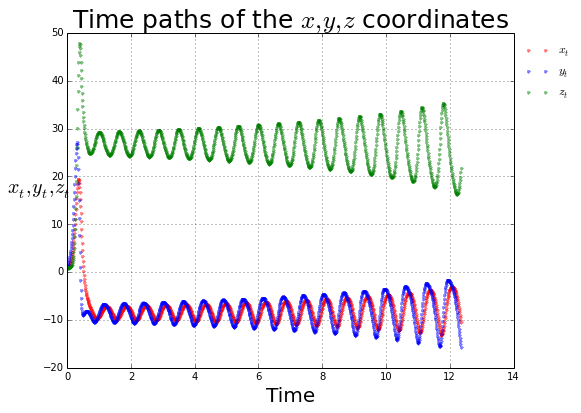

In [59]:
@interact(T=IntSliderWidget(min=0, value=0, max=solution.shape[0], step=5))
def plot_lorenz(T):
    """Plots the first T points in the solution trajectory of the Lorenz equations.""" 
    # extract the components of the solution trajectory
    t = solution[:T, 0]
    x_vals = solution[:T, 1]
    y_vals = solution[:T, 2]
    z_vals = solution[:T, 3]

    # create the plot
    fig = plt.figure(figsize=(8, 6))
    plt.plot(t, x_vals, 'r.', label='$x_t$', alpha=0.5)
    plt.plot(t, y_vals  , 'b.', label='$y_t$', alpha=0.5)
    plt.plot(t, z_vals  , 'g.', label='$z_t$', alpha=0.5)

    plt.grid()
    plt.xlabel('Time', fontsize=20)
    plt.ylabel('$x_t, y_t, z_t$', fontsize=20, rotation='horizontal')
    plt.title('Time paths of the $x,y,z$ coordinates', fontsize=25)
    plt.legend(frameon=False, bbox_to_anchor=(1.15,1))
    
    plt.show()

#### Step 2: Construct a continuous approximation to the solution.

Let's construct a continuous approximation to the solution of the Lorenz equations at 10000 evenly spaced points using a 5th order B-spline interpolation.

In [33]:
# define the desired interpolation points...
ti = np.linspace(t0, solution[-1, 0], 1e4)

# ...and interpolate!
interp_solution = lorenz_ivp.interpolate(solution, ti, k=5, ext=2)

#### Plotting 2D projections of the solution in phase space
The underlying structure of the Lorenz system becomes more apparent when I plot the interpolated solution trajectories in phase space. We can plot 2D projections of the time paths of the solution in phase space...

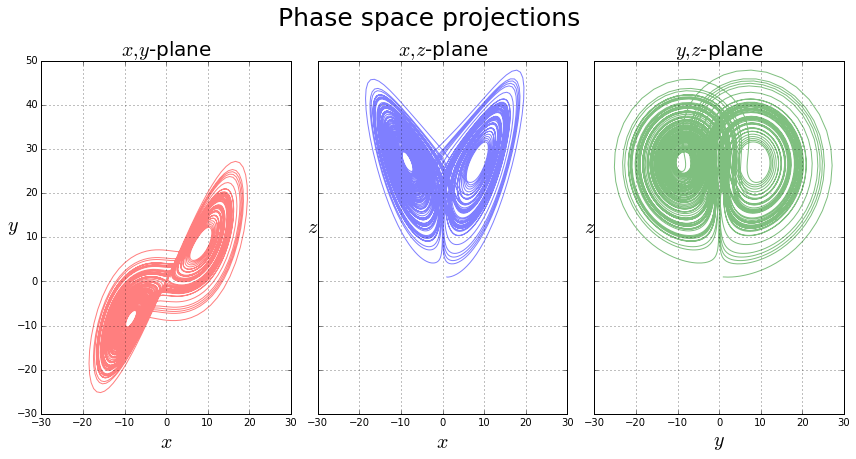

In [34]:
# extract the components of the solution trajectory
t = solution[:, 0]
x_vals = interp_solution[:, 1]
y_vals = interp_solution[:, 2]
z_vals = interp_solution[:, 3]

# xy phase space projection
fig, axes = plt.subplots(1, 3, figsize=(12, 6), sharex=True, sharey=True, squeeze=False)
axes[0,0].plot(x_vals, y_vals, 'r', alpha=0.5)
axes[0,0].set_xlabel('$x$', fontsize=20, rotation='horizontal')
axes[0,0].set_ylabel('$y$', fontsize=20, rotation='horizontal')
axes[0,0].set_title('$x,y$-plane', fontsize=20)
axes[0,0].grid()

# xz phase space projection
axes[0,1].plot(x_vals, z_vals  , 'b', alpha=0.5)
axes[0,1].set_xlabel('$x$', fontsize=20, rotation='horizontal')
axes[0,1].set_ylabel('$z$', fontsize=20, rotation='horizontal')
axes[0,1].set_title('$x,z$-plane', fontsize=20)
axes[0,1].grid()

# yz phase space projection
axes[0,2].plot(y_vals, z_vals  , 'g', alpha=0.5)
axes[0,2].set_xlabel('$y$', fontsize=20, rotation='horizontal')
axes[0,2].set_ylabel('$z$', fontsize=20, rotation='horizontal')
axes[0,2].set_title('$y,z$-plane', fontsize=20)
axes[0,2].grid()

plt.suptitle('Phase space projections', x=0.5, y=1.05, fontsize=25)
plt.tight_layout()
plt.show()

#### Step 3: Compute the residuals to assese the accuracy of our solution

Finally, to assess the accuracy of our solution we need to compute and plot the solution residuals at 10000 evenly spaced points using a 5th order B-spline interpolation.

In [35]:
# compute the residual
ti = np.linspace(0, solution[-1,0], 10000)
residual = lorenz_ivp.compute_residual(solution, ti, k=5)

Again, we want to confirm that the residuals are "small" everywhere. Patterns, if they exists, are not cause for concern.

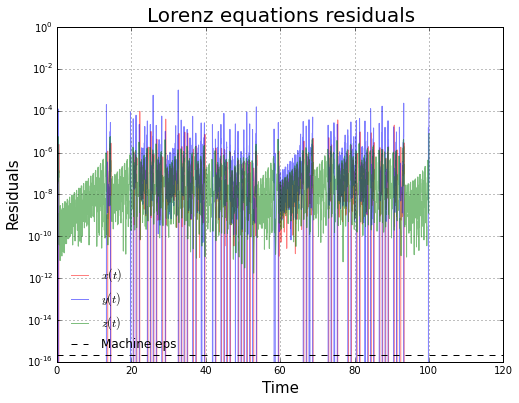

In [36]:
# extract the raw residuals
x_residuals = residual[:, 1]
y_residuals = residual[:, 2]
z_residuals = residual[:, 3]

# typically, normalize residual by the level of the variable
norm_x_residuals = np.abs(x_residuals) / x_vals
norm_y_residuals = np.abs(y_residuals) / y_vals
norm_z_residuals = np.abs(z_residuals) / z_vals

# create the plot
fig = plt.figure(figsize=(8, 6))
plt.plot(ti, norm_x_residuals, 'r-', label='$x(t)$', alpha=0.5)
plt.plot(ti, norm_y_residuals, 'b-', label='$y(t)$', alpha=0.5)
plt.plot(ti, norm_z_residuals, 'g-', label='$z(t)$', alpha=0.5)
plt.axhline(np.finfo('float').eps, linestyle='dashed', color='k', label='Machine eps')
plt.xlabel('Time', fontsize=15)
plt.ylim(1e-16, 1)
plt.ylabel('Residuals', fontsize=15)
plt.yscale('log')
plt.title('Lorenz equations residuals', fontsize=20)
plt.grid()
plt.legend(loc='best', frameon=False)
plt.show()